# PowerCo Business & Data Science case

## Introduction

The data for this case study was provided with the courtesy of BCG Gamma during one of their workshop at HEC Paris. Customer's data was fully anonymized. 

We study client's data from an energy company. **The goal is to predict churn, and then propose a solution to avoid it.**

In other words : What clients are expected to leave the company ? How to prevent them from doing so ?

In this notebook, 

1. We import, format and clean company's raw client data. 
2. We predict churn using two machine learning techniques : **random forests and artificial neural networks.** We compare their performance on relevant metrics. 
3. We propose a way to avoid churn : offering a discount, set as to maximize company's overall profit.

## 1. Data preprocessing

The data was provided by PowerCo as it was extracted from their databases. 

In [3]:
import pandas as pd
import numpy as np

In [4]:
# Importing client's data. Those were anonymized.  
pricing_df = pd.read_csv('data/Pricing data.csv')
energy_df = pd.read_csv('data/Energy usage data.csv')
finance_df = pd.read_csv('data/Finance data.csv')
crm_df = pd.read_csv('data/CRM data.csv')
sales_channel_df = pd.read_csv('data/Sales channel data.csv')
forecast_df = pd.read_csv('data/Forecast data.csv')

### 1.a Preprocessing of pricing data

Energy prices depends on a lot of factor, from who's the client, to the date of the month. The dataset `pricing_df` contains the daily pricing for energy of the last 12 days for each client. 

First, we need to unstack the columns. This is how the client stores data, but not how we need it to be. 

Then, we need to fill missing values. Indeed, some companies have only 10 days of pricing data instead of 12. We do so using *forward fill*. 

In [5]:
#Pricing_df preprocessing : custom functions we'll use. 

def sample_df_by_id(df, size=100, by_id='id'):
    """Samples (size) items in column (by_id) of (df),
    then returns all the items of (df) with these (by_id)"""
    # This function was useful during development to avoid testing the 
    # preprocessing each time on the whole dataset. 
    sample_id = pd.Series(df[by_id].unique()).sample(size)
    
    sample_df = df[df[by_id].isin(sample_id)]
    return sample_df

def preprocess_price(df, new_row='id', new_column='price_date'):
    """Custom preprocessing to unstack, reindex and flatten columns, 
    and to propagate missing data."""
    others_s = pricing_df.columns.tolist()
    #To unstack columns, we build a pivot table. 
    df = df.pivot_table(values=others_s, index=new_row, columns=new_column, aggfunc=(lambda x: x))
    df = df.reset_index()
    df.columns = df.columns.to_flat_index()
    #Filling NA values with backfill, from left to right
    for i, _id in df.iterrows():
        if i%100==0: print('row', i, '/', df.shape[0])
        df.iloc[i,:] = df.iloc[i,:].fillna(method='ffill') #.fillna(0)
    return df

In [6]:
#Preprocessing prices. Lengthy process due to filling NA values line by line. 

# sample = sample_df_by_id(proc_pricing_df)
# preprocess_sales(sample)
proc_pricing_df = preprocess_price(pricing_df)
proc_pricing_df.shape

row 0 / 16094
row 100 / 16094
row 200 / 16094
row 300 / 16094
row 400 / 16094
row 500 / 16094
row 600 / 16094
row 700 / 16094
row 800 / 16094
row 900 / 16094
row 1000 / 16094
row 1100 / 16094
row 1200 / 16094
row 1300 / 16094
row 1400 / 16094
row 1500 / 16094
row 1600 / 16094
row 1700 / 16094
row 1800 / 16094
row 1900 / 16094
row 2000 / 16094
row 2100 / 16094
row 2200 / 16094
row 2300 / 16094
row 2400 / 16094
row 2500 / 16094
row 2600 / 16094
row 2700 / 16094
row 2800 / 16094
row 2900 / 16094
row 3000 / 16094
row 3100 / 16094
row 3200 / 16094
row 3300 / 16094
row 3400 / 16094
row 3500 / 16094
row 3600 / 16094
row 3700 / 16094
row 3800 / 16094
row 3900 / 16094
row 4000 / 16094
row 4100 / 16094
row 4200 / 16094
row 4300 / 16094
row 4400 / 16094
row 4500 / 16094
row 4600 / 16094
row 4700 / 16094
row 4800 / 16094
row 4900 / 16094
row 5000 / 16094
row 5100 / 16094
row 5200 / 16094
row 5300 / 16094
row 5400 / 16094
row 5500 / 16094
row 5600 / 16094
row 5700 / 16094
row 5800 / 16094
row 5900 

### 1.b Preprocessing of Sales Channel data

This additionnal dataset contains information about client's activity (exact labelling was anonymized).

Thus, this data is categorical and needs to be transformed.

In [0]:
def preprocess_sales(df):
    # We replace the encoding (t, f) by (1, 0)
    df['also_gas_client'].replace({'t': 1, 'f': 0}, inplace=True)
    # We use get_dummies to encode categorical data. 
    cols = list(sales_channel_df)
    cols.remove('id')
    cols.remove('also_gas_client')
    df = pd.get_dummies(df, columns=cols, dummy_na=True)
    return df

#sample = sample_df_by_id(sales_channel_df.copy())
#preprocess_sales(sample)
proc_sales_channel_df = sales_channel_df.copy()
proc_sales_channel_df = preprocess_sales(proc_sales_channel_df)
proc_sales_channel_df.shape

### 1.c Merging all the datasets

The other datasets are quite "data science ready" and require minimal preprocessing. 

We merge all the datasets into one big single datasets that we'll use for training our models. 

In [0]:
#Merging datasets

proc_pricing_df = proc_pricing_df.rename(columns={('id', ''): 'id'})
merged_df = proc_pricing_df.merge(energy_df, on="id", how="left")
merged_df = merged_df.merge(finance_df, on="id", how="left")
merged_df = merged_df.merge(crm_df, on="id", how="left")

# This last dataset has a lot of missing values in some columns. We remove these columns. 
#forecas_df = forecast_df.drop(['forecast_ele_bill_next_01m', 
#                               'forecast_ele_bill_next_calyear',
#                               'forecast_ele_bill_next_12m',
#                               'forecast_consumption_ele_next_01m'], axis=1)

#merged_df = merged_df.merge(forecast_df)
merged_df = merged_df.merge(proc_sales_channel_df)

for c in merged_df.columns:
    if "Unnamed" in c:
        merged_df = merged_df.drop(c, 1)

merged_df

Lastly, during training and data exploration, incoherent values were found :

- negative energy consumption
- strings were numbers were supposed to be found

We remove the rows were such errors were found. 

In [0]:
#Cleaning weird values

cleaned_df = merged_df[merged_df["obs_consumption_ele_last_12m"]>=0]
cleaned_df = cleaned_df[cleaned_df["obs_consumption_gas_last_12m"]>=0]
cleaned_df = cleaned_df[cleaned_df["obs_consumption_ele_last_01m"]>=0]

#We have some funky values in these columns. We replace them by na. 
cols = [('price_p1_fix', '2015-01-01'), ('price_p1_fix', '2015-02-01'), ('price_p1_fix', '2015-03-01'), 
     ('price_p1_fix', '2015-04-01'), ('price_p1_fix', '2015-05-01')]
cleaned_df[cols] = cleaned_df[cols].replace(regex='.*[a-zA-Z]+.*', value=np.nan)

cleaned_df = cleaned_df.dropna()
cleaned_df

## 2. Building prediction model

Using the previously built and cleaned dataset, we build a prediction model. 

In [0]:
#Building X and y matrices
to_predict = 'target_churned'
features = list(cleaned_df.columns)
features.remove(to_predict)
features.remove('id')

X = np.array(cleaned_df[features])
y = np.array(cleaned_df[to_predict]) 

#Normalizing values

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X = sc.fit_transform(X)

In [0]:
#Train and test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

### 2.a Random forest

Random forest is an easy out-of-the box algorithm for classification. We'll use it as a baseline. 

In [0]:
#Baseline : randomforest

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, max_depth=10)
clf.fit(X_train, y_train)

### 2.b Evaluating the model

How good is the model we trained ? Let's check.

`clf.score()` returns the accuracy of the model. That is, how many times our model was right. Here, it says that about 90% of our predictions are correct.

In [20]:
clf.score(X_test, y_test)

0.9019670050761421

But in the dataset, 90% of the clients don't churn. Which means that a model always saying that client will never churn would also get a score of 90% !

In [21]:
# Proportion of client that don't churn in the dataset : 90% !
# Rougly speaking, a dumb classifier always saying "the client will never churn" would get an accuracy of 90%.
# But would be totally useless.
1-sum(y)/len(y)

0.9018848765627975

Business-wise, such a model (which always says a client won't churn) is not useful at all. Another metric, more precise, is needed.

In our case, a more relevant metric is the AUC. The AUC is the area under the ROC curve. Closer it is to 1, the better is our model not only at predicting, but also at **discriminating**. That is, at saying which clients will churn *and* which clients won't churn. 

In [22]:
from sklearn.metrics import roc_auc_score

# With this metric, our previous "dumb" classifier which always predict "the client will never churn"
# would only get a score of 50%. How better is our model ?
preds = clf.predict_proba(X_test)[:,1]
print('ROC AUC score: ', roc_auc_score(y_test, preds)) #more than 50%, which is great ! The model is useful. 

ROC AUC score:  0.6918241248874486


### 2.c Artificial Neural Networks

Can we improve on the previous random forest model ? 

To compare the two models, we will use the AUC metric, for the reasons evoked before. 

In [153]:
# Building the neural network

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

n = len(features)

clf_nn = Sequential()
clf_nn.add(Dense(units=128, activation = 'relu', kernel_initializer='uniform', input_shape=(n,)))
# To avoid overfitting, we add Dropout layers. 
clf_nn.add(Dropout(rate=0.2))
clf_nn.add(Dense(units=32, activation = 'relu', kernel_initializer='uniform'))
clf_nn.add(Dropout(rate=0.2))
clf_nn.add(Dense(units=32, activation = 'relu', kernel_initializer='uniform'))
clf_nn.add(Dropout(rate=0.2))
# This is a classification task. There is only one output varying between 0 and 1, which is the
# probability of the client churning. 
clf_nn.add(Dense(units=1, activation = 'sigmoid', kernel_initializer='uniform'))

clf_nn.compile(optimizer='nadam',
              loss='binary_crossentropy',
              metrics=['accuracy', 'AUC'])

In [132]:
582# Loading the NN

clf_nn.load_weights('model/nn')

In [154]:
# Training the NN. 150 epochs

# For further training, we save this NN in a file. 
clf_nn.fit(X_train, y_train, batch_size=32, epochs=50)
clf_nn.save_weights('model/nn')

Train on 12605 samples
Epoch 1/50
12605/12605 [==============================] - 4s 330us/sample - loss: 0.3434 - accuracy: 0.9006 - AUC: 0.5605
Epoch 2/50
12605/12605 [==============================] - 3s 241us/sample - loss: 0.3137 - accuracy: 0.9019 - AUC: 0.6320
Epoch 3/50
12605/12605 [==============================] - 3s 255us/sample - loss: 0.3071 - accuracy: 0.9019 - AUC: 0.6549
Epoch 4/50
12605/12605 [==============================] - 3s 231us/sample - loss: 0.3041 - accuracy: 0.9019 - AUC: 0.6699
Epoch 5/50
12605/12605 [==============================] - 4s 284us/sample - loss: 0.3021 - accuracy: 0.9027 - AUC: 0.6737
Epoch 6/50
12605/12605 [==============================] - 4s 278us/sample - loss: 0.3001 - accuracy: 0.9037 - AUC: 0.6806
Epoch 7/50
12605/12605 [==============================] - 4s 293us/sample - loss: 0.2983 - accuracy: 0.9039 - AUC: 0.6859
Epoch 8/50
12605/12605 [==============================] - 3s 263us/sample - loss: 0.2971 - accuracy: 0.9042 - AUC: 0.6874
E

In [155]:
preds_nn = clf_nn.predict(X_test)[:,0]
print('ROC AUC score: ', roc_auc_score(y_test, preds_nn)) 

ROC AUC score:  0.6239989891711545


Sadly, this AUC is slightly worse than the Random forest one. Does this mean that the neural network model is inferior ?

Well, from a mathematical standpoint, yes. 

**But how do these models compare from a business standpoint ?** How good are they at actually preventing churn at PowerCo ? 

## 3. Avoiding churn

The two models we built return a value between 0 and 1 associated with the probability of the client churning. 

Let's assume that to prevent a client from churning, PowerCo issues a 15% discount on their electricity price. We also assume that this definitively deters the client from churning. 

PowerCo doesn't want either to lose a client and is ready to give it a discount. But PowerCo, however, doesn't want to hand out free discounts. Above which churn probability should PowerCo issues its 15% discount ?  

In [143]:
import matplotlib.pyplot as plt

def test_model(y, preds, margins, DISCOUNT_RATE=0.15):
    """Test a model by calculating the margin saved when applying a discount,
    taking into account discounts wrongly applied to non-churning clients. """
    def find_best_p(preds, discount, granularity=200):
        """Optimization function to find the best probability cutoff"""
        probas = np.linspace(0, 1, granularity)
        output_margins = np.zeros(len(probas))
        actual_churners = (y == 1)

        gains = np.sum(margins)
        loss = sum(margins[actual_churners])

        for i, p in enumerate(probas):
            predicted_churners = preds>=p
            prevented_loss = sum(margins[predicted_churners & actual_churners])
            # To make calculations easier, we assume that the discount
            # is operated on the net margin. It could actually be a bit more. 
            discount_loss = sum(margins[predicted_churners])*discount
            output_margins[i] = gains - loss + prevented_loss - discount_loss

        best_profit = max(output_margins)
        best_p_index = list(output_margins).index(best_profit)
        best_p = probas[best_p_index]
        worst_profit = gains - loss
        return probas, output_margins, best_p, best_profit, worst_profit
    
    # Textual and graphical output interpreting the result
    probas, output_margins, best_p, best_profit, worst_profit = find_best_p(preds, DISCOUNT_RATE, 200)
    print('Above a', round(best_p,4), 'predicted probability of churn, we should apply the', DISCOUNT_RATE*100, '% discount to the client.')
    print('If we do so, we\'ll save', round(best_profit-worst_profit,2), '(', round((best_profit-worst_profit)/,2) '€ of net margin.')

    plt.plot(probas, output_margins)
    plt.axvline(x=best_p, color='red')
    plt.show()

Let's first see how do they compare on the whole dataset.

Random forest model
Above a 0.1357 predicted probability of churn, we should apply the 15.0 % discount to the client.
If we do so, we'll save 183896.75 € of net margin.


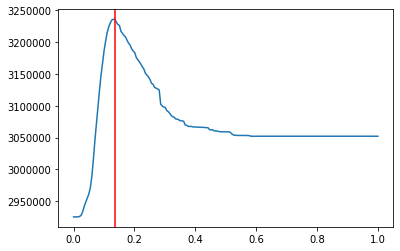

Neural network model
Above a 0.1759 predicted probability of churn, we should apply the 15.0 % discount to the client.
If we do so, we'll save 155351.7 € of net margin.


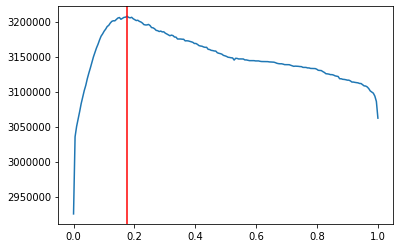

In [156]:
_X = X
_y = y
margins = sc.inverse_transform(_X)[:,list(cleaned_df.columns).index('net_margin_ele')]

print('Random forest model')
preds = clf.predict_proba(_X)[:,1]
test_model(_y, preds, margins)

print('Neural network model')
preds = clf_nn.predict_proba(_X)[:,0]
test_model(_y, preds, margins)

On only the test dataset, results are similar.

Random forest model
Above a 0.1307 predicted probability of churn, we should apply the 15.0 % discount to the client.
If we do so, we'll save 30142.34 € of net margin.


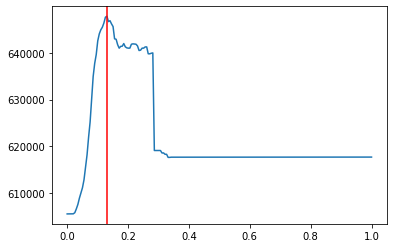

Neural network model
Above a 0.1759 predicted probability of churn, we should apply the 15.0 % discount to the client.
If we do so, we'll save 8423.56 € of net margin.


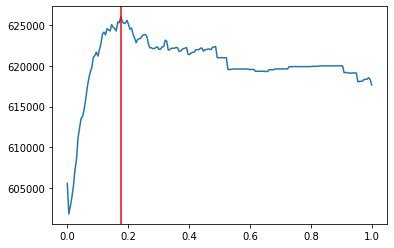

In [157]:
_X = X_test
_y = y_test
margins = sc.inverse_transform(_X)[:,list(cleaned_df.columns).index('net_margin_ele')]

print('Random forest model')
preds = clf.predict_proba(_X)[:,1]
test_model(_y, preds, margins)

print('Neural network model')
preds = clf_nn.predict_proba(_X)[:,0]
test_model(_y, preds, margins)

The neural network model is much worse than the rando! Speaking in money, the neural network model is more than three times worse than the random forest one. 

## Conclusion

The best model (Random forest) can save PowerCo about 180 000€ in net margin, simply by offering 15% discount to clients likely to churn. 